In [1]:
import os
from pathlib import Path
import requests
import datetime
import json
import pandas as pd
import numpy as np
%matplotlib inline

from alpha_vantage.timeseries import TimeSeries


In [2]:
from numpy.random import seed
seed(23)
from tensorflow import random

random.set_seed(32)

In [3]:
ts = TimeSeries(key='alpha_vantage_api')

# Get json object with the daily price data and another with  the call's metadata


#SPDR S&P 500 ETF 
sp500_etf_data, sp500_etf_meta_data = ts.get_daily('SPY', outputsize='full')
sp500_etf_data['2020-06-30']

{'1. open': '303.9900',
 '2. high': '310.2000',
 '3. low': '303.8200',
 '4. close': '308.3600',
 '5. volume': '112828251'}

In [4]:
df = []
for x in sp500_etf_data:
        date = x
        close = sp500_etf_data[x]['4. close']
        df.append({
            "Date": date,
            "Close": close,
        })
tickers_df = pd.DataFrame(df)
tickers_df = tickers_df[['Date', 'Close']]
#tickers_df.sort_values(by='Date', ascending = False, inplace=True)
tickers_df['Date']= pd.to_datetime(tickers_df['Date'])
tickers_df.set_index("Date", inplace=True)
tickers_df.tail()

Close
Date                
2000-07-14  151.2500
2000-07-13  149.7812
2000-07-12  149.1250
2000-07-11  148.1562
2000-07-10  147.8437

In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

### 2. Creating the features (X) and target (y) data using the window_data() function

In [6]:
window_size = 60
feature_column = 0
target_column = 0

X, y = window_data(tickers_df, window_size, feature_column, target_column)
# print (f"X sample values:\n{X[:5]} \n")
# print (f"y sample values:\n{y[:5]}")

### 3. Splitting Data Into Training and Testing

In [7]:
# Splitting 80% of the data for training and the remainder for testing.
split = int(0.80 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

### 4. Scale Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### 5. Reshape Data

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

### 6. Build and Train Model

In [10]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# a. Define the LSTM RNN model.
model = Sequential()

 # Initial model setup
number_units = 60
dropout_fraction = 0.4

 # Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

 # Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

 # Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

 # Output layer
model.add(Dense(1))

In [12]:
# b. Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
# c. Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            14880     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=30, verbose=1)

Epoch 1/20
133/133 [==============================] - 16s 117ms/step - loss: 0.0259
Epoch 2/20
133/133 [==============================] - 15s 113ms/step - loss: 0.0107
Epoch 3/20
133/133 [==============================] - 16s 119ms/step - loss: 0.0110
Epoch 4/20
133/133 [==============================] - 17s 126ms/step - loss: 0.0103
Epoch 5/20
133/133 [==============================] - 17s 128ms/step - loss: 0.0084
Epoch 6/20
133/133 [==============================] - 16s 120ms/step - loss: 0.0073
Epoch 7/20
133/133 [==============================] - 16s 121ms/step - loss: 0.0076
Epoch 8/20
133/133 [==============================] - 16s 120ms/step - loss: 0.0077
Epoch 9/20
133/133 [==============================] - 16s 121ms/step - loss: 0.0092
Epoch 10/20
133/133 [==============================] - 16s 122ms/step - loss: 0.0124
Epoch 11/20
133/133 [==============================] - 16s 123ms/step - loss: 0.0150
Epoch 12/20
133/133 [==============================] - 16s 123ms/step - lo

### 7. Make Predictions

In [15]:
# a. Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [16]:
# b. Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})

# Show the DataFrame's head
stocks.head()

Actual   Predicted
0  113.45  113.828835
1  113.84  114.123871
2  114.39  114.382652
3  114.75  114.622986
4  113.77  114.860870

### 8. Evaluate Model Performance

In [17]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0001293784735025838

### 9. Plot

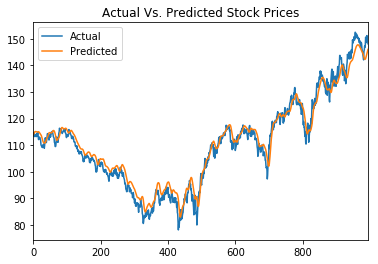

In [18]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted Stock Prices")

### 10. Create DataFrame for GLD Prices

In [19]:
#SPDR Gold ETF 
gold_etf_data, gold_etf_meta_data = ts.get_daily('GLD', outputsize='full')
gold_etf_data['2020-06-30']

{'1. open': '166.3100',
 '2. high': '167.9906',
 '3. low': '166.1850',
 '4. close': '167.3700',
 '5. volume': '12746655'}

In [20]:
gold_df = []
for x in gold_etf_data:
        date = x
        close = gold_etf_data[x]['4. close']
        gold_df.append({
            "Date": date,
            "Close": close,
        })
gold_tickers_df = pd.DataFrame(gold_df)
gold_tickers_df = gold_tickers_df[['Date', 'Close']]
#tickers_df.sort_values(by='Date', ascending = False, inplace=True)
gold_tickers_df['Date']= pd.to_datetime(gold_tickers_df['Date'])
gold_tickers_df.set_index("Date", inplace=True)
gold_tickers_df.tail()

Close
Date               
2004-11-24  45.0500
2004-11-23  44.7500
2004-11-22  44.9500
2004-11-19  44.7800
2004-11-18  44.3800

In [21]:
def gold_window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    gold_X = []
    gold_y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        gold_X.append(features)
        gold_y.append(target)
    return np.array(gold_X), np.array(y).reshape(-1, 1)

### 11. Creating the features (X) and target (y) data using the window_data() function

In [22]:
gold_X, gold_y = window_data(gold_tickers_df, window_size, feature_column, target_column)

### 12. Splitting Data Into Training and Testing

In [23]:
gold_split = int(0.80 * len(gold_X))
gold_X_train = gold_X[: gold_split - 1]
gold_X_test = gold_X[gold_split:]
gold_y_train = gold_y[: gold_split - 1]
gold_y_test = gold_y[gold_split:]

### 13. Scale Data

In [24]:
scaler.fit(gold_X)
gold_X_train = scaler.transform(gold_X_train)
gold_X_test = scaler.transform(gold_X_test)
scaler.fit(gold_y)
gold_y_train = scaler.transform(gold_y_train)
gold_y_test = scaler.transform(gold_y_test)

### 14. Reshape Data

In [25]:
gold_X_train = gold_X_train.reshape((gold_X_train.shape[0], gold_X_train.shape[1], 1))
gold_X_test = gold_X_test.reshape((gold_X_test.shape[0], gold_X_test.shape[1], 1))

### 15. Build Model

In [26]:
gold_model = Sequential()

 # Initial model setup
number_units = 60
dropout_fraction = 0.4

 # Layer 1
gold_model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(gold_X_train.shape[1], 1))
    )
gold_model.add(Dropout(dropout_fraction))

 # Layer 2
gold_model.add(LSTM(units=number_units, return_sequences=True))
gold_model.add(Dropout(dropout_fraction))

 # Layer 3
gold_model.add(LSTM(units=number_units))
gold_model.add(Dropout(dropout_fraction))

 # Output layer
gold_model.add(Dense(1))

In [27]:
gold_model.compile(optimizer="adam", loss="mean_squared_error")

### 16. Train Model

In [32]:
gold_model.fit(gold_X_train, gold_y_train, epochs=20, shuffle=False, batch_size=50, verbose=1)

Epoch 1/20
62/62 [==============================] - 9s 144ms/step - loss: 0.0111
Epoch 2/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0052
Epoch 3/20
62/62 [==============================] - 9s 144ms/step - loss: 0.0047
Epoch 4/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0036
Epoch 5/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0023
Epoch 6/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0019
Epoch 7/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0016
Epoch 8/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0015
Epoch 9/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0015
Epoch 10/20
62/62 [==============================] - 9s 144ms/step - loss: 0.0014
Epoch 11/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0014
Epoch 12/20
62/62 [==============================] - 9s 143ms/step - loss: 0.0013
Epoch 13/20
62/62 [======

### 17. Make Predictions

In [33]:
gold_predicted = gold_model.predict(gold_X_test)

gold_predicted_prices = scaler.inverse_transform(gold_predicted)
gold_real_prices = scaler.inverse_transform(gold_y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
gold = pd.DataFrame({
    "Actual": gold_real_prices.ravel(),
    "Predicted": gold_predicted_prices.ravel()
})

# Show the DataFrame's head
gold.head()

Actual  Predicted
0   79.24  76.957703
1   79.25  76.506294
2   78.13  76.292305
3   78.52  76.120720
4   78.50  76.036949

### 18. Evaluate Model Performance 

In [34]:
gold_model.evaluate(gold_X_test, gold_y_test, verbose=0)

0.0014035749481990933

### 19. Plot

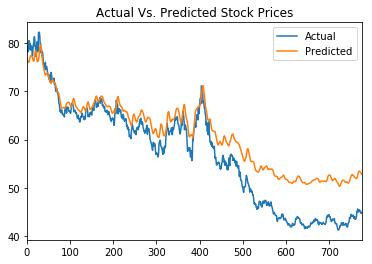

In [35]:
gold.plot(title="Actual Vs. Predicted Stock Prices")

In [39]:
from sklearn.metrics import r2_score

sp500_R2_score = r2_score(y_test, predicted)
print(f"The R2 score for the SPY is {sp500_R2_score}.")

The R2 score for the SPY is 0.9676905638405079.


In [40]:
gold_R2_score = r2_score(gold_y_test, gold_predicted)
print(f"The R2 score for the GLD is {gold_R2_score}.")

The R2 score for the GLD is 0.7593763803580302.


In [43]:
from sklearn.metrics import explained_variance_score

sp500_var_score = explained_variance_score(y_test, predicted, multioutput='uniform_average')
print(f"The Explained Variance Score for SPY is {sp500_var_score}.")

The Explained Variance Score for SPY is 0.9705131554150297.


In [44]:
gold_var_score = explained_variance_score(gold_y_test, gold_predicted, multioutput='uniform_average')
print(f"The Explained Variance Score for GLD is {gold_var_score}.")

The Explained Variance Score for GLD is 0.8986236878870566.


In [47]:
from sklearn.metrics import max_error

sp500_max_error = max_error(y_test, predicted)
print(f"The Max Error for SPY is {sp500_max_error}.")

The Max Error for SPY is 0.04183035200377033.


In [48]:
gold_max_error = max_error(gold_y_test, gold_predicted)
print(f"The Max Error for GLD is {gold_max_error}.")

The Max Error for GLD is 0.06719478050961974.
